<a href="https://colab.research.google.com/github/MartaCampagnoli/HateSpeechDetection/blob/main/Output%20Notebooks/Classification_Part1_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries
from gensim.models import Word2Vec
from google.colab import files
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from string import punctuation
import xgboost as xgb
import gensim.downloader
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
#personalized set of stopwords
stopwords = nltk.corpus.stopwords.words('english')
exceptions = ["no", "not" , "don't", "they", "them"]
stop = [word for word in stopwords if word not in exceptions]
#stemmer
stemmer = nltk.SnowballStemmer("english")

In [ ]:
#preprocessing function: stemming and stopwords removal
def preprocess(text):
    text = ''.join([word for word in text])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop]
    tokens = [stemmer.stem(w) for w in tokens]
    return ' '.join(tokens)

In [ ]:
def encode_df(dataframe): #label encoder
    le = LabelEncoder()
    for column in dataframe.columns:
        dataframe['label'] = le.fit_transform(dataframe['label'])
    return dataframe

In [ ]:
uploaded = files.upload() #cleandata.csv

Saving cleandata.csv to cleandata.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['cleandata.csv']))

In [ ]:
df = encode_df(df)

In [ ]:
train, test = train_test_split(df ,test_size=0.30, random_state = 42)

In [ ]:
#setting training and test
X_train, X_test, y_train, y_test = train['text'], test['text'], train['label'], test['label']

In [ ]:
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [ ]:
#tf idf
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

In [ ]:
#word2vec
sentences = [sentence.split() for sentence in X_train]

## XGBoost TFIDF

In [ ]:
xgbtf = xgb.XGBClassifier()
xgbtf.fit(X_train_tf, y_train)

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      6633
           1       0.66      0.67      0.66      5711

    accuracy                           0.69     12344
   macro avg       0.68      0.68      0.68     12344
weighted avg       0.69      0.69      0.69     12344



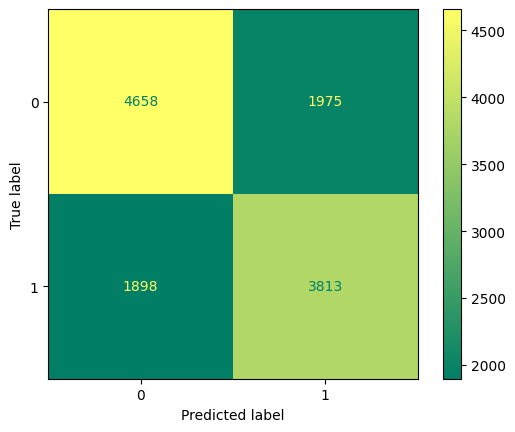

In [ ]:
y_pred = xgbtf.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

## Logistic Regression TFIDF

In [ ]:
lrtf = LogisticRegression(solver='sag', verbose = 1)
lrtf.fit(X_train_tf, y_train)

              precision    recall  f1-score   support

           0       0.69      0.72      0.70      6633
           1       0.66      0.62      0.64      5711

    accuracy                           0.67     12344
   macro avg       0.67      0.67      0.67     12344
weighted avg       0.67      0.67      0.67     12344



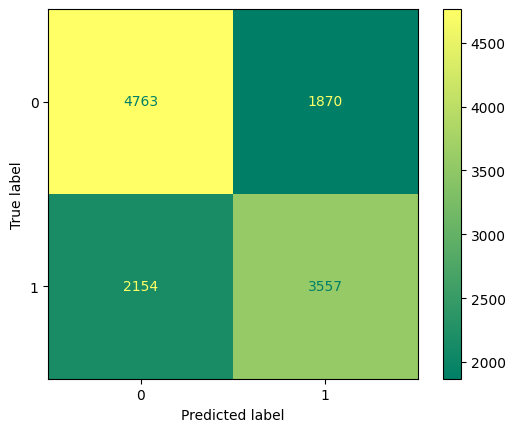

In [ ]:
y_pred = lrtf.predict(X_test_tf)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

## SGD TFIDF

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6633
           1       0.66      0.64      0.65      5711

    accuracy                           0.68     12344
   macro avg       0.68      0.68      0.68     12344
weighted avg       0.68      0.68      0.68     12344



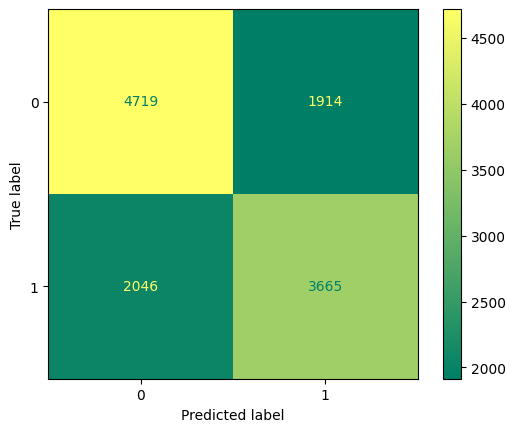

In [ ]:
#sgd
sgdtf = SGDClassifier(random_state=5)
sgdtf.fit(X_train_tf, y_train)
y_pred = sgdtf.predict(X_test_tf)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

## Word2vec: training the embeddings

In [ ]:
w2v_model = Word2Vec(sentences, vector_size=300, window=2, min_count=10, workers=4)

In [ ]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
X_trainw2c = np.array([vectorize(sentence) for sentence in X_train])
X_testw2c = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
#xgboost
xgtrainw = xgb.XGBClassifier()
xgtrainw.fit(X_trainw2c, y_train)

              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6633
           1       0.56      0.51      0.53      5711

    accuracy                           0.59     12344
   macro avg       0.58      0.58      0.58     12344
weighted avg       0.59      0.59      0.59     12344



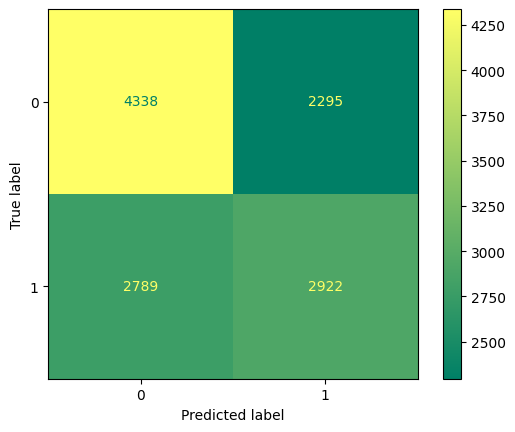

In [ ]:
y_pred = xgtrainw.predict(X_testw2c)
print(metrics.classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

              precision    recall  f1-score   support

           0       0.57      0.94      0.71      6633
           1       0.72      0.19      0.30      5711

    accuracy                           0.59     12344
   macro avg       0.65      0.56      0.51     12344
weighted avg       0.64      0.59      0.52     12344



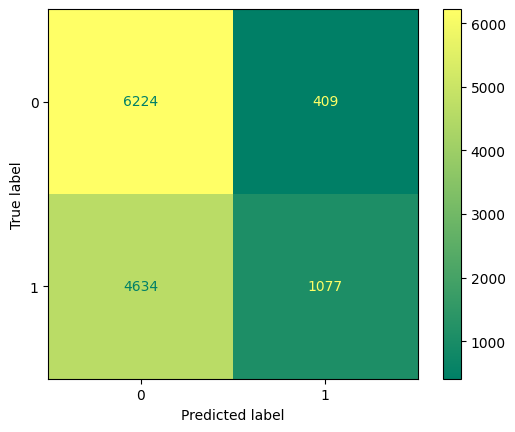

In [ ]:
#sgd
sgdtrainw = SGDClassifier(random_state=5)
sgdtrainw.fit(X_trainw2c, y_train)
y_pred = sgdtrainw.predict(X_testw2c)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

## Word2Vec: pretrained embeddings

In [ ]:
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
w2vvectors =  gensim.downloader.load('word2vec-google-news-300')
textfast = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def vectorizew2c(sentence):
    words = sentence.split()
    words_vecs = [w2vvectors[word] for word in words if word in w2vvectors]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

def vectorizetextfast(sentence):
    words = sentence.split()
    words_vecs = [textfast[word] for word in words if word in textfast]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)


In [ ]:
#word2vec

In [ ]:
X_trainvec = np.array([vectorizew2c(sentence) for sentence in X_train])
X_testvec = np.array([vectorizew2c(sentence) for sentence in X_test])

In [ ]:
xgbw2v = xgb.XGBClassifier()
xgbw2v.fit(X_trainvec, y_train)

              precision    recall  f1-score   support

           0       0.63      0.66      0.64      6633
           1       0.58      0.54      0.56      5711

    accuracy                           0.61     12344
   macro avg       0.60      0.60      0.60     12344
weighted avg       0.60      0.61      0.60     12344



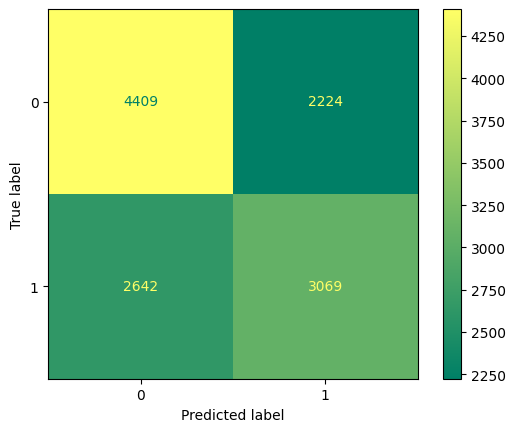

In [ ]:
y_pred = xgbw2v.predict(X_testvec)
print(metrics.classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')

In [ ]:
#fasttext

In [ ]:
X_traintext = np.array([vectorizetextfast(sentence) for sentence in X_train])
X_testtext = np.array([vectorizetextfast(sentence) for sentence in X_test])

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      6633
           1       0.59      0.54      0.56      5711

    accuracy                           0.61     12344
   macro avg       0.61      0.61      0.61     12344
weighted avg       0.61      0.61      0.61     12344



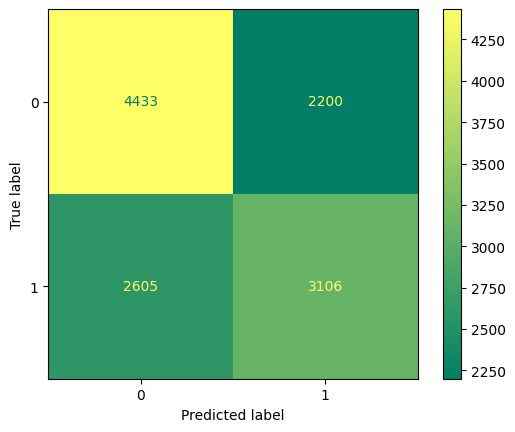

In [ ]:
xgbtext = xgb.XGBClassifier()
xgbtext.fit(X_traintext, y_train)
y_pred = xgbtext.predict(X_testtext)
print(metrics.classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'summer')